In [1]:
import warnings
warnings.filterwarnings('ignore')

# Import Neccessary libraries
import numpy as np 
import pandas as pd 

# Import Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Import Model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

#Import Sampler libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

# Set the decimal format
pd.options.display.float_format = "{:.2f}".format

# Explore the head of the files

In [2]:
df = pd.read_csv("Data/diabetes_prediction_dataset.csv")
df.head()


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.00,0,1,never,25.19,6.60,140,0
1,Female,54.00,0,0,No Info,27.32,6.60,80,0
2,Male,28.00,0,0,never,27.32,5.70,158,0
3,Female,36.00,0,0,current,23.45,5.00,155,0
4,Male,76.00,1,1,current,20.14,4.80,155,0


# Data cleansing will do this following task 
- finding duplicated rows and remove them
- finding missing values
- Oberserve the uniqueness of value

In [3]:
# initial number of rows 
initial_row_count = df.shape[0]
print("Number of duplicate rows: ", df.shape[0])
# Handle duplicates
duplicate_rows_data = df[df.duplicated()]
print("Number of duplicate rows: ", duplicate_rows_data.shape[0])
df = df.drop_duplicates()
print("After removed: ", df.shape[0])
# Missing values
print(df.isnull().sum())




Number of duplicate rows:  100000
Number of duplicate rows:  3854
After removed:  96146
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


In [4]:
# Loop through each column and count the number of unique_vals
for column in df.columns:
    unique_val = len(df[column].unique())
    print(f"{column}: {unique_val} distinct values")


gender: 3 distinct values
age: 102 distinct values
hypertension: 2 distinct values
heart_disease: 2 distinct values
smoking_history: 6 distinct values
bmi: 4247 distinct values
HbA1c_level: 18 distinct values
blood_glucose_level: 18 distinct values
diabetes: 2 distinct values


# Data virtualization where we look at the plot of the data for better understanding of the data

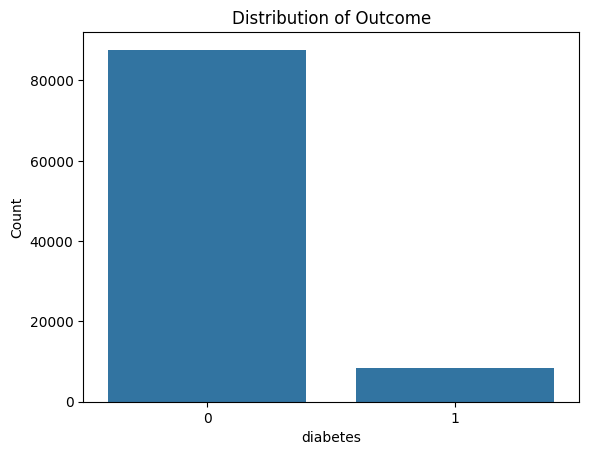

In [5]:
sns.countplot(x='diabetes', data=df)
plt.title('Distribution of Outcome')
plt.xlabel('diabetes')
plt.ylabel('Count')
plt.show()

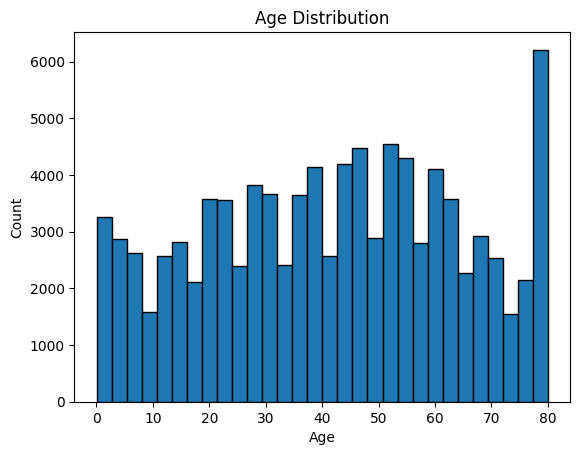

In [6]:
# Plot histogram for age ( histogram showing the frequency distribution of single continuous variable )
plt.hist(df['age'], bins=30, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

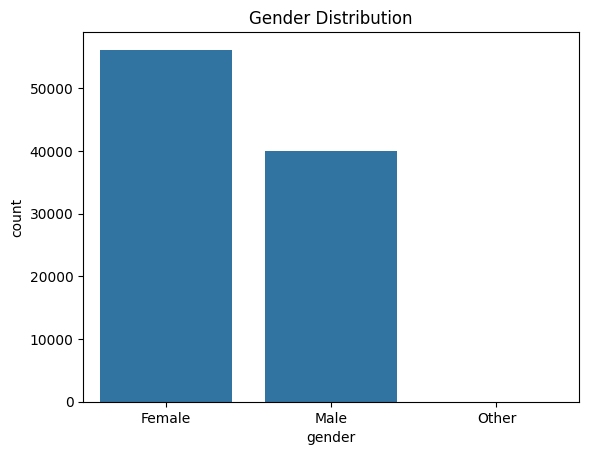

In [7]:
# Bar plot for gender
sns.countplot(x='gender', data=df)
plt.title('Gender Distribution')
plt.show()

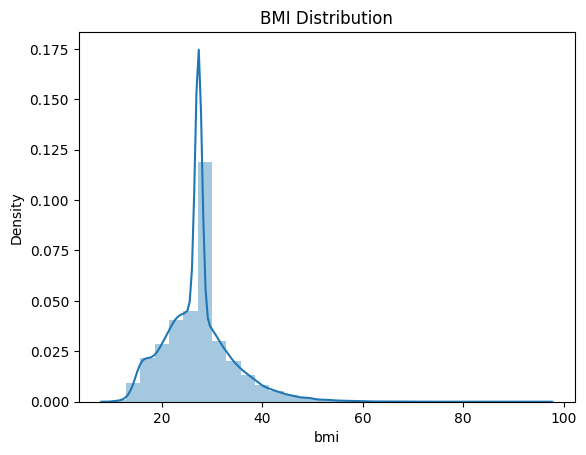

In [8]:
# Distribution plot for BMI
sns.distplot(df['bmi'], bins=30)
plt.title('BMI Distribution')
plt.show()

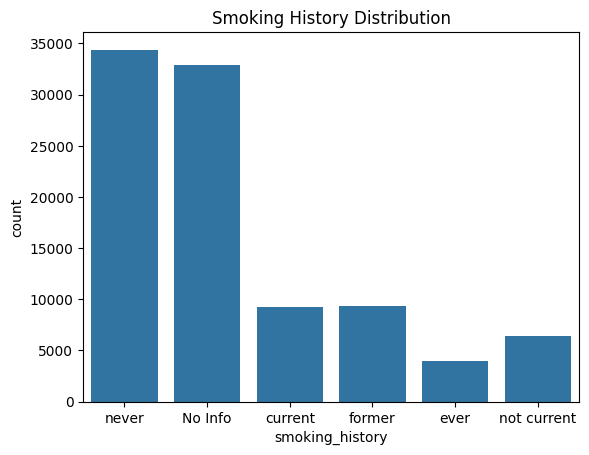

In [9]:
# Count plot for smoking history
sns.countplot(x='smoking_history', data=df)
plt.title('Smoking History Distribution')
plt.show()

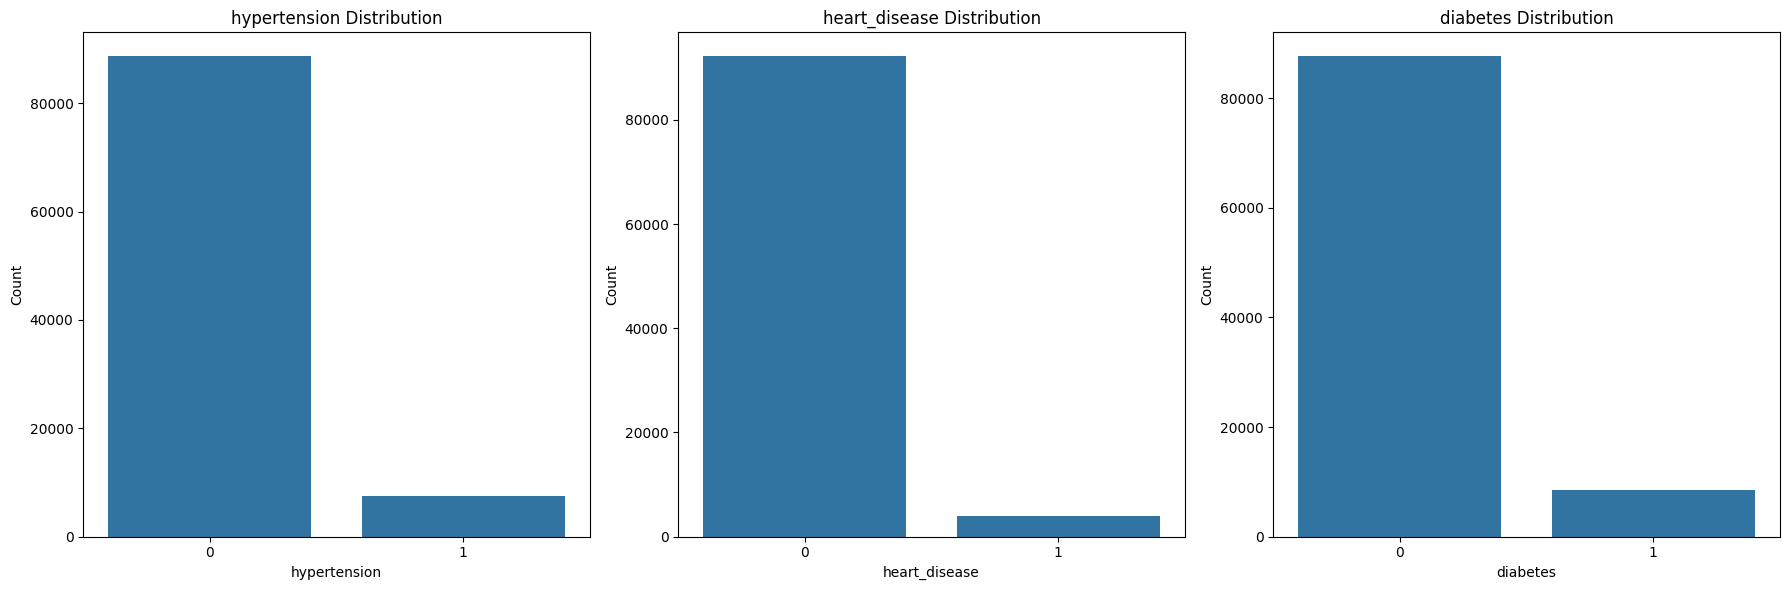

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# List of columns to plot
columns = ['hypertension', 'heart_disease', 'diabetes']

# Create a count plot for each column
for ax, col in zip(axes, columns):
    sns.countplot(x=col, data=df, ax=ax)
    ax.set_title(f'{col} Distribution')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()

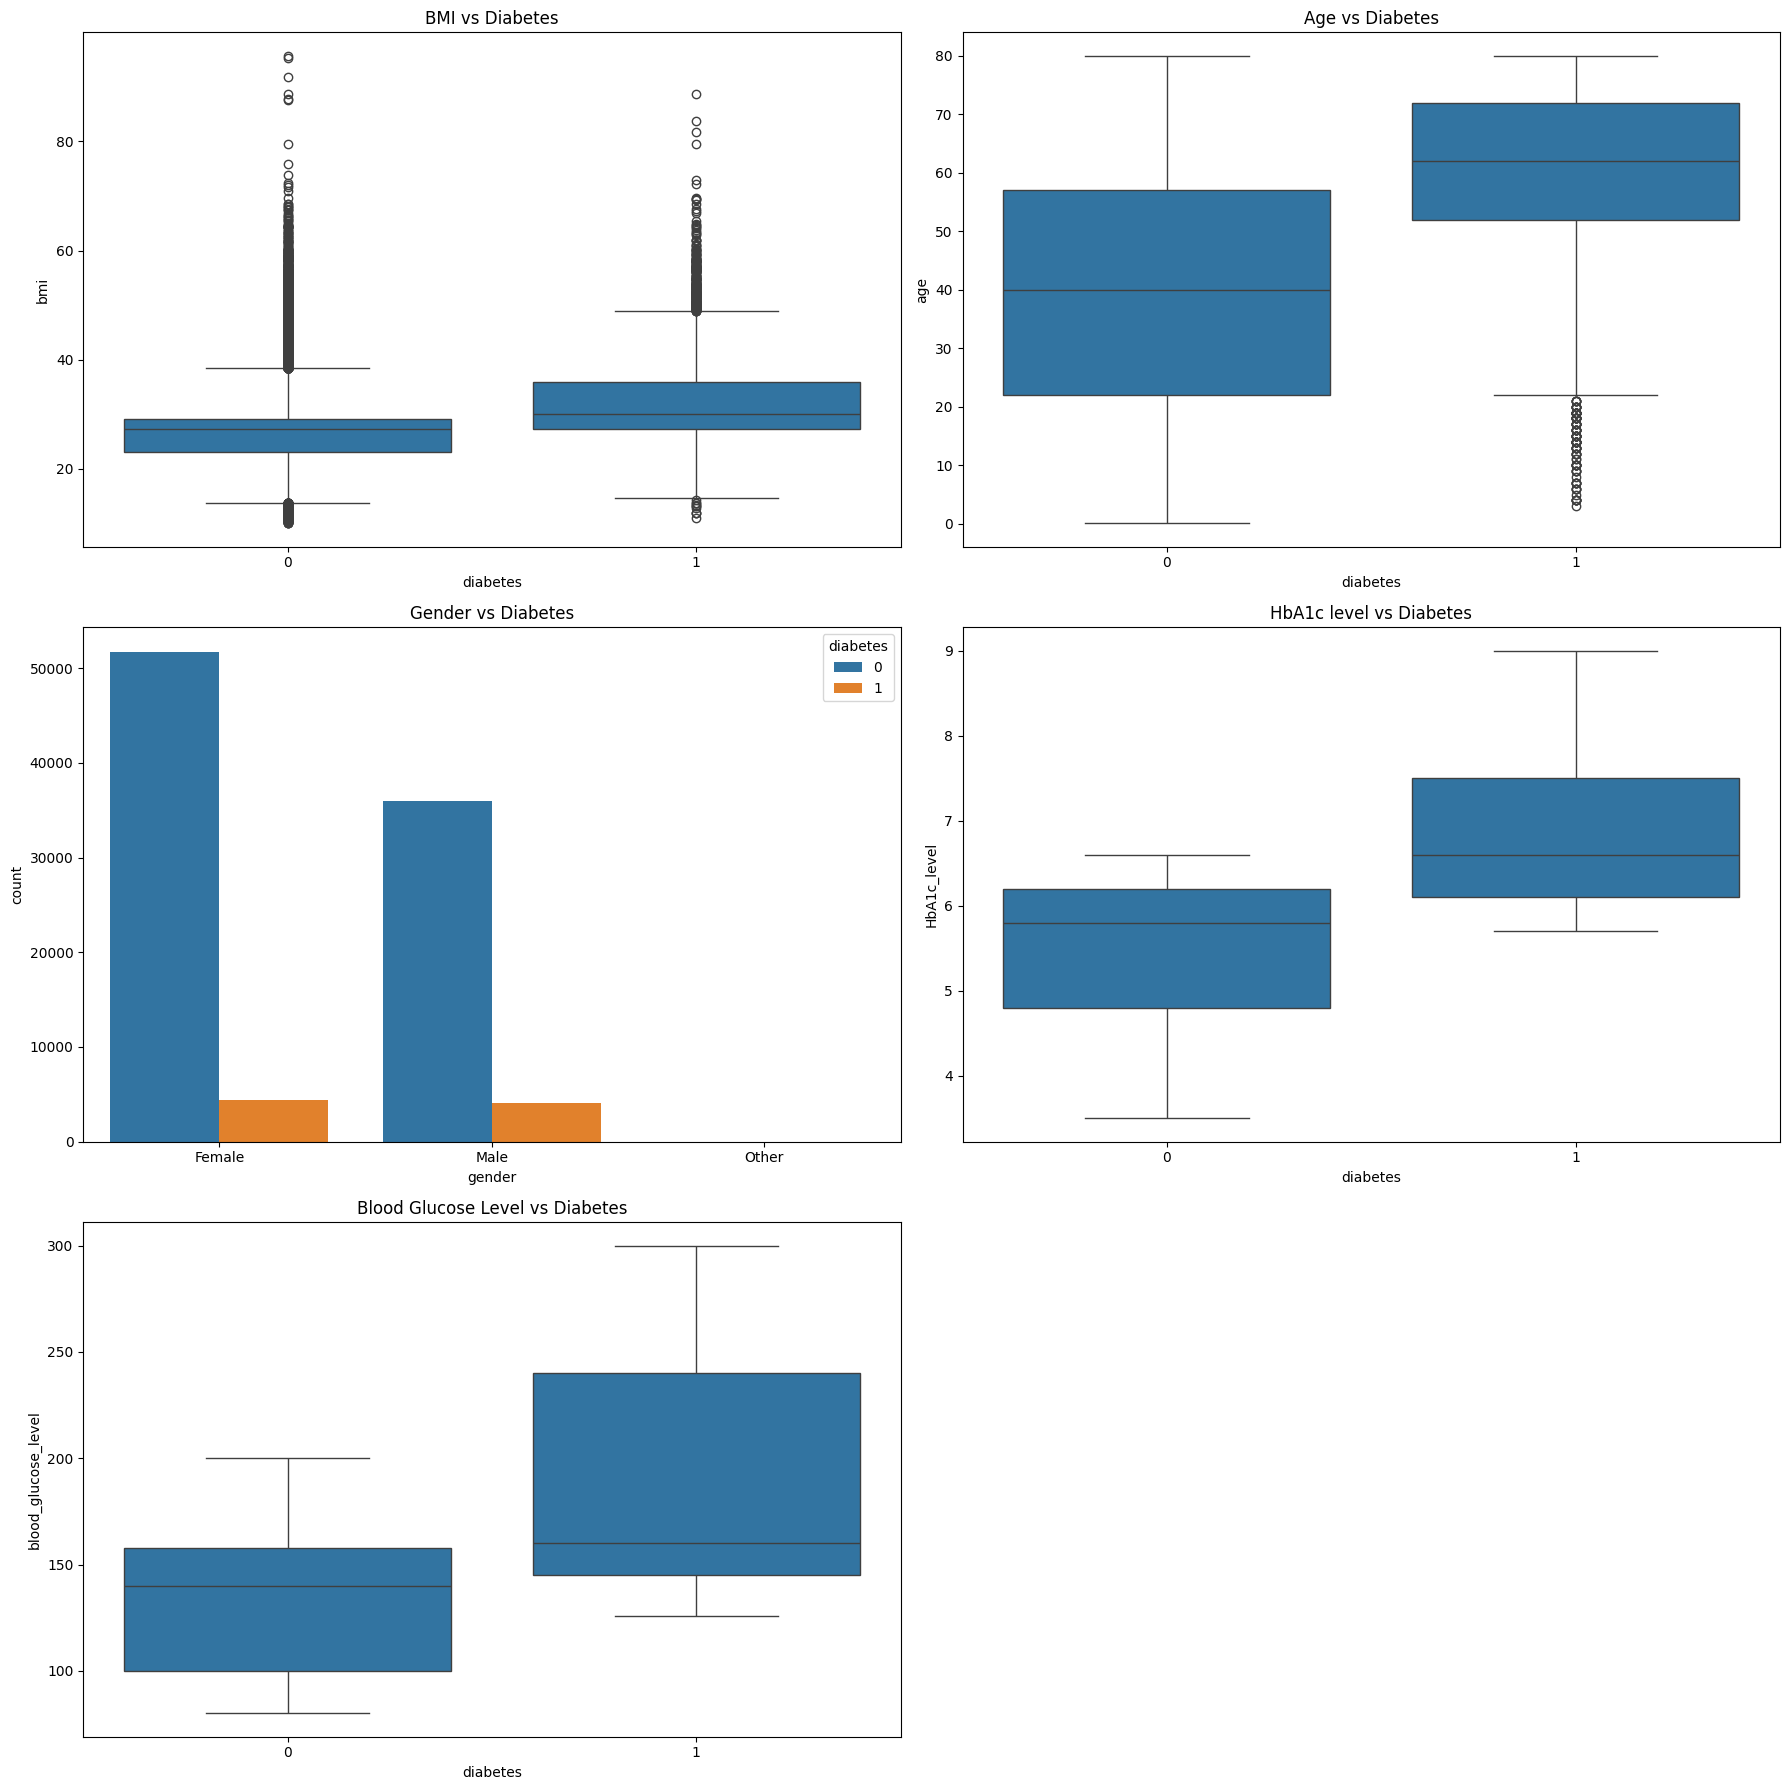

In [11]:
# Set up the matplotlib figure
fig, axes = plt.subplots(3, 2, figsize=(18, 18))

# Boxplot for BMI vs Diabetes
sns.boxplot(x='diabetes', y='bmi', data=df, ax=axes[0, 0])
axes[0, 0].set_title('BMI vs Diabetes')

# Boxplot for Age vs Diabetes
sns.boxplot(x='diabetes', y='age', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Age vs Diabetes')

# Countplot for Gender vs Diabetes
sns.countplot(x='gender', hue='diabetes', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Gender vs Diabetes')

# Boxplot for HbA1c level vs Diabetes
sns.boxplot(x='diabetes', y='HbA1c_level', data=df, ax=axes[1, 1])
axes[1, 1].set_title('HbA1c level vs Diabetes')

# Boxplot for Blood Glucose Level vs Diabetes
sns.boxplot(x='diabetes', y='blood_glucose_level', data=df, ax=axes[2, 0])
axes[2, 0].set_title('Blood Glucose Level vs Diabetes')

# Hide the empty subplot (bottom right)
fig.delaxes(axes[2, 1])

# Adjust layout
plt.tight_layout()
plt.show()

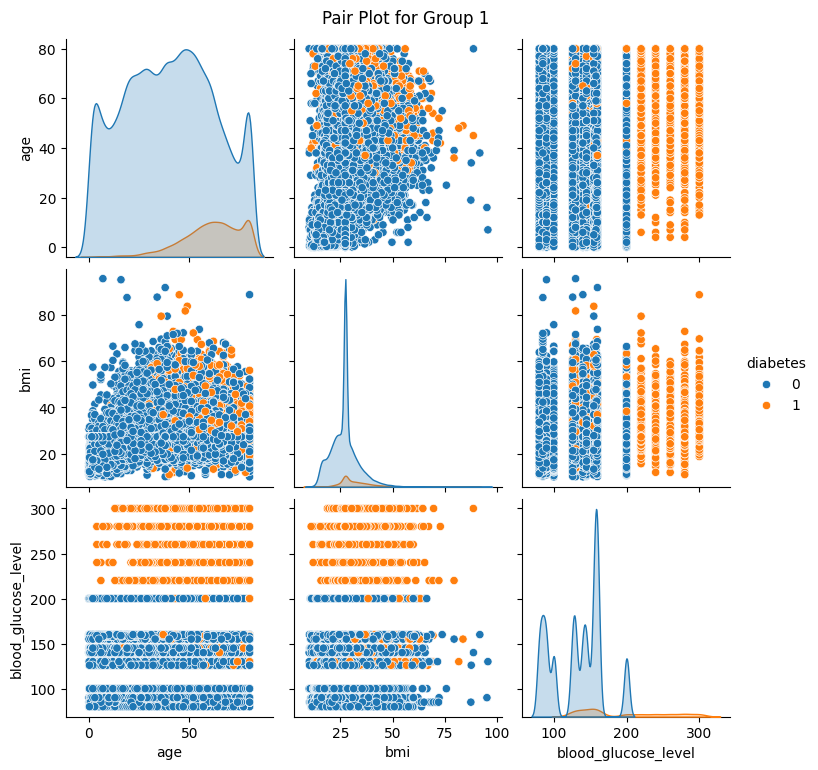

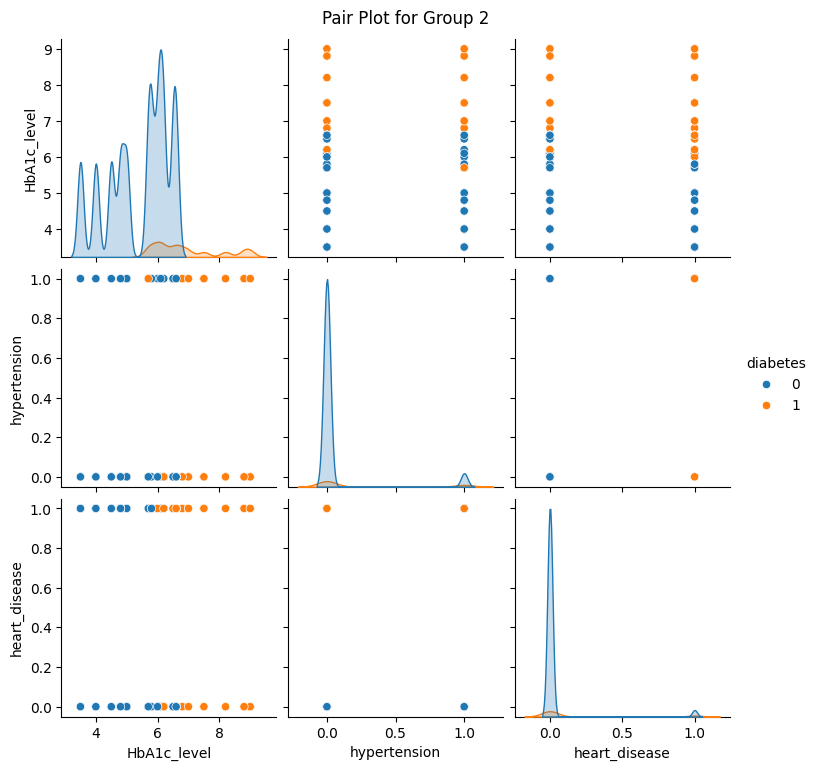

In [12]:
# List of features to plot
features = ['age', 'bmi', 'blood_glucose_level', 'HbA1c_level', 'hypertension', 'heart_disease']

# Split the features into two groups
features_group1 = ['age', 'bmi', 'blood_glucose_level']
features_group2 = ['HbA1c_level', 'hypertension', 'heart_disease']

# Create pair plots for each group
# Group 1
sns.pairplot(df[features_group1 + ['diabetes']], hue='diabetes')
plt.suptitle('Pair Plot for Group 1', y=1.02)
plt.show()

# Group 2
sns.pairplot(df[features_group2 + ['diabetes']], hue='diabetes')
plt.suptitle('Pair Plot for Group 2', y=1.02)
plt.show()

# After virtualized the data we found out that
- unbalance labels number of people with diabetes is significantly lower than none diabete ( we might apply the SMOTE to oversampling the minority class)




# Data preparation

In [13]:
# filtered gender to have only two (less informative feature)

df = df[df['gender'] != 'Other']

# As well as 

In [14]:
# One hot encoding -> transform categorical variables into numerical form (gender , smoking_history)

# Function to perform one-hot encoding
def perform_one_hot_encoding(df, column_name):
    dummies = pd.get_dummies(df[column_name], prefix=column_name)
    df = pd.concat([df.drop(column_name, axis=1), dummies], axis=1)
    return df

# Perform one-hot encoding on the gender variable
df = perform_one_hot_encoding(df, 'gender')

# Perform one-hot encoding on the smoking_history variable
df = perform_one_hot_encoding(df, 'smoking_history')

# Correlation
- to observe and mearsure the relationship between two caiables and how they move together.
- +1: Perfect positive correlation. As one variable increases, the other also increases
- -1: Perfect negative correlation. As one variable increases, the other decreases.
- 0: No correlation. The variables do not have any linear relationship.

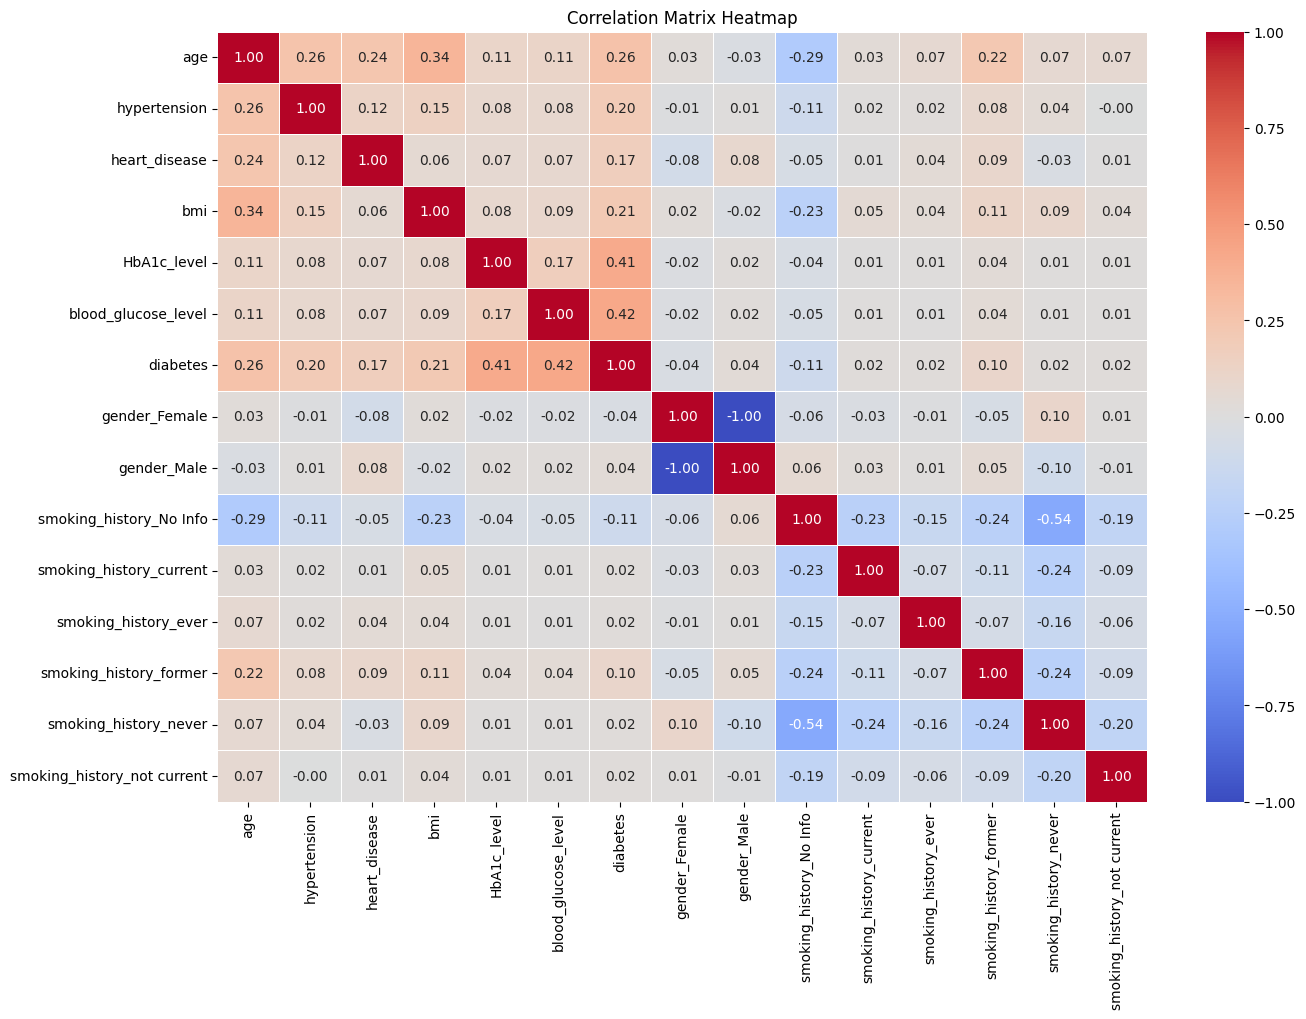

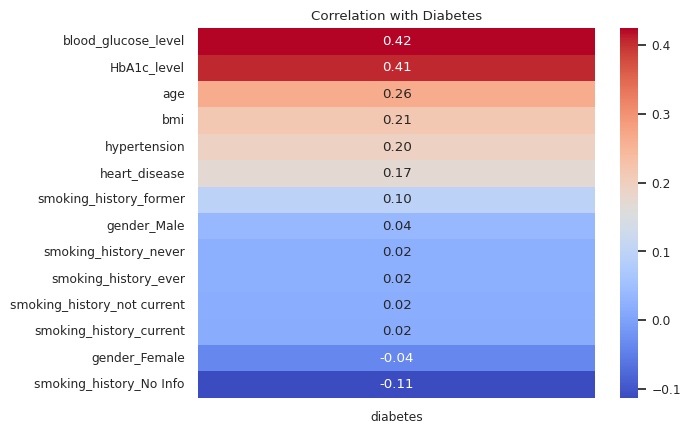

In [15]:
# Compute the correlation matrix
correlation_matrix = df.corr()
#Graph I.
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()


#Graph II
# Create a heatmap of the correlations with the target column
corr = df.corr()
target_corr = corr['diabetes'].drop('diabetes')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Diabetes')
plt.show()

# split the data and seperate features and Target 
- input feature x , target variable y
- train and test split
# Apply Oversample and Undersample to training set (keep testing as actual data with out synthetic data included)
- Oversample the minority class (prevent moel bias to majority class)
- Undersample the majority class

# Split the original dataset
- split : training set is 85 % of original , test set is 15% of original
- the training set will be pationate into 5 set and apply five-fold cross validation ( the validation set will iterate through the each partion to oberve the model accuracy)
- test set will be use as final model evaluation and should not contain synthetic or oversample data as it should be keep in from of real world application



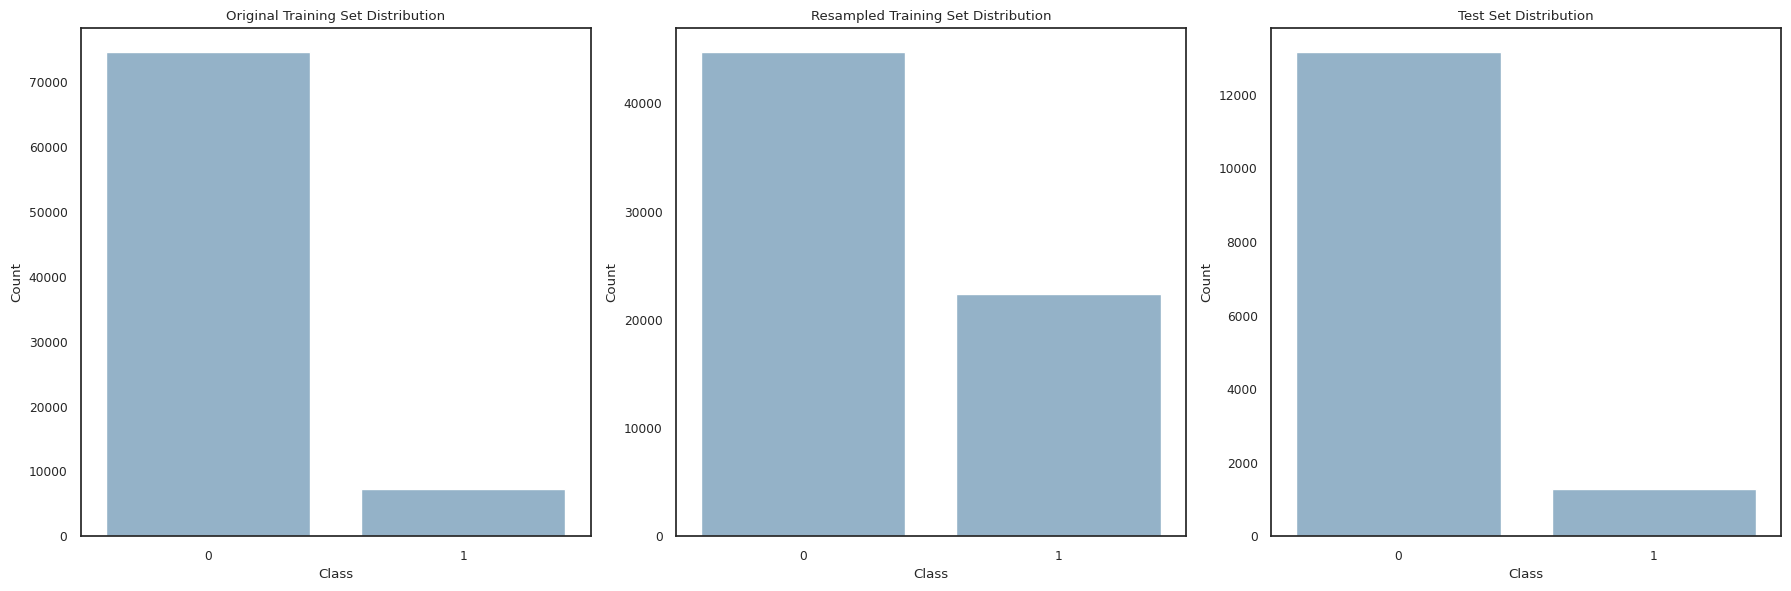

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Separate features and target variable
X = df.drop('diabetes', axis=1)
y = df['diabetes']

# Split the data into training and test sets (85% train, 15% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# Define resampling
over = SMOTE(sampling_strategy=0.3, random_state=42)  # Oversample the minority class to reach 30% of the majority class
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # Undersample the majority class to 50% of its original size

# Create a pipeline for resampling
resampling_pipeline = Pipeline(steps=[('o', over), ('u', under)])

# Apply the resampling to the training data
X_resampled, y_resampled = resampling_pipeline.fit_resample(X_train, y_train)



# Plot the class distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original training set distribution
sns.countplot(ax=axes[0], x=y_train)
axes[0].set_title('Original Training Set Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

# Resampled training set distribution
sns.countplot(ax=axes[1], x=y_resampled)
axes[1].set_title('Resampled Training Set Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

# Test set distribution
sns.countplot(ax=axes[2], x=y_test)
axes[2].set_title('Test Set Distribution')
axes[2].set_xlabel('Class')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()



# Preprocessing: Standardize numerical features
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
X_test = scaler.transform(X_test)




# Train the model and find the best combination of hyperparameter

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   5.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   5.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   7.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   8.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   8.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  10.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  11.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  13.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   6.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=

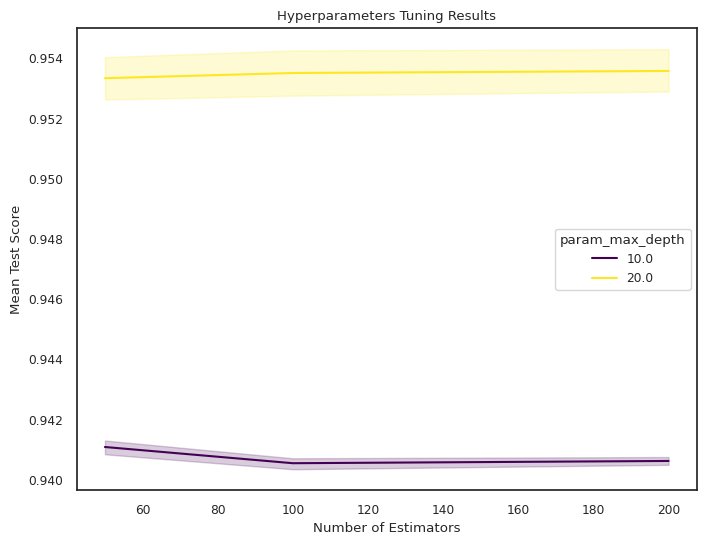

In [17]:
# Define the model
clf = RandomForestClassifier(random_state=42)

# Define the hyperparameters and the values we want to test
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create Grid Search object
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, verbose=2)

# Train the model with grid search
grid_search.fit(X_resampled, y_resampled)

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

# Evaluate the final model on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test Set Score: ", test_score)

# Visualize the results of hyperparameter tuning
results_df = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(8, 6))
sns.lineplot(data=results_df, x='param_n_estimators', y='mean_test_score', hue='param_max_depth', palette='viridis')
plt.title('Hyperparameters Tuning Results')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score')
plt.show()

In [18]:
print("Best Parameters: ", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Evaluate the final model on the test set
test_score = best_model.score(X_test, y_test)
print("Test Set Score: ", test_score)



Best Parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Test Set Score:  0.9616504854368932


Model Accuracy:  0.9616504854368932
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     13148
           1       0.82      0.73      0.77      1272

    accuracy                           0.96     14420
   macro avg       0.90      0.86      0.87     14420
weighted avg       0.96      0.96      0.96     14420



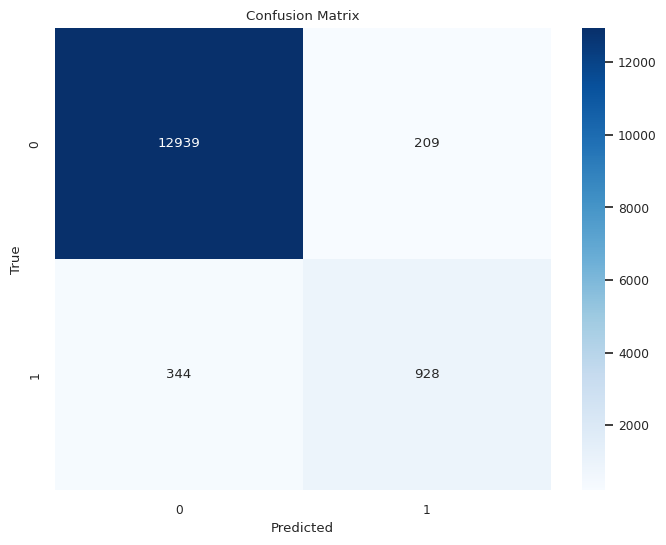

In [19]:
# Predict on the test set using the best model
y_pred = grid_search.predict(X_test)

# Evaluate the model
print("Model Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

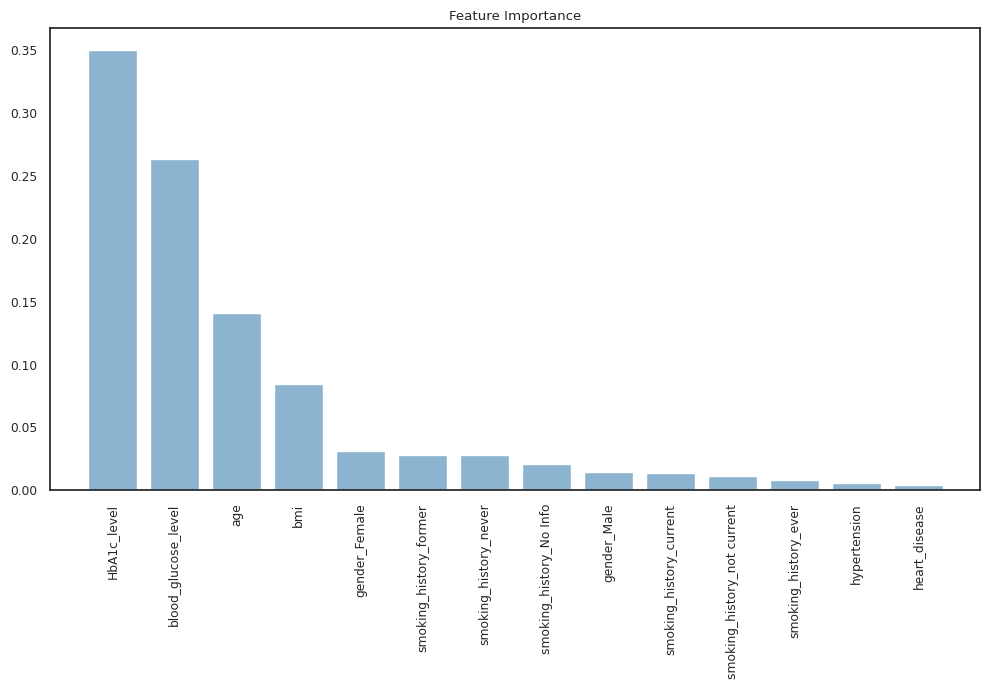

In [20]:
# Plot feature importance
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

plt.figure(figsize=(12, 6))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [21]:
import joblib

# Save the model to a file
Model_joblib_file = "Model/best_model_diabetes.pkl"
Scaler_joblib_file = "Model/scaler.pkl"

joblib.dump(best_model, Model_joblib_file)
joblib.dump(scaler, Scaler_joblib_file)

['Model/scaler.pkl']